# Сравнение архитектур: CNN, RNN и SSM

В этом ноутбуке реализованы и сравниваются три модели для задачи `pixel-level 1‑D image classification`:

1. **LSTM** — разновидность RNN;
2. **1D CNN** — одномерная свёрточная сеть;
3. **S4D-Lin** — State Space Model из статьи [On the Parameterization and Initialization of Diagonal State Space Models](https://arxiv.org/abs/2206.11893).

Дополнительно рассмотрим **2D CNN** как baseline для `region-level image classification`, чтобы понять, можно ли при попиксельной классификации приблизиться к качеству 2D CNN или ViT.


## 0. Импорты и настройки

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Optional
from tqdm import tqdm


BATCH_SIZE = 128
SEQ_LEN = 28 * 28
INPUT_SIZE = 1
N_EPOCHS = 10
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

Device: cuda


## 1. Данные

Чтобы модели обучались достаточно быстро, возьмём датасет [MNIST](https://docs.pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html) — изображения рукописных цифр 28×28 в оттенках серого, 10 классов.

Для наших целей нужен датасет относительно длинных последовательностей, но MNIST — это двумерные картинки. Как превратить изображение в последовательность? Просто вытянем изображение в вектор по пикселям. Из таких вытянутых картинок составим датасет и будем называть его `sequential MNIST или sMNIST`.

In [2]:
transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.1307), (0.3081)),
])

class sMNIST(torch.utils.data.Dataset):
    def __init__(self, dataset, seq_len=784):
        self.dataset = dataset
        self.seq_len = seq_len

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img = self.dataset[idx][0]
        label = self.dataset[idx][1]
        return img.view(-1, 1), label

# 2D MNIST
mnist_dataset = {
    "train": torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform),
    "test":  torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform),
}

# 1D sMNIST
sMnist_dataset = {
    "train": sMNIST(mnist_dataset["train"], seq_len=SEQ_LEN),
    "test":  sMNIST(mnist_dataset["train"], seq_len=SEQ_LEN),
}

mnist_loader = {
    "train": DataLoader(mnist_dataset["train"], batch_size=BATCH_SIZE, shuffle=True, num_workers=2),
    "test":  DataLoader(mnist_dataset["test"], batch_size=BATCH_SIZE, shuffle=False, num_workers=0),
}

sMnist_loader = {
    "train": DataLoader(sMnist_dataset["train"], batch_size=BATCH_SIZE, shuffle=True, num_workers=2),
    "test":  DataLoader(sMnist_dataset["test"], batch_size=BATCH_SIZE, shuffle=False, num_workers=0),
}

100%|██████████| 9.91M/9.91M [00:00<00:00, 44.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.21MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 11.2MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.82MB/s]


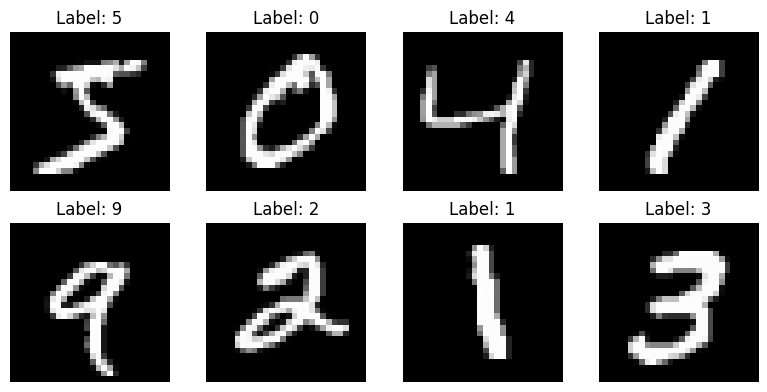

In [3]:
fig, axs = plt.subplots(2, 4, figsize=(8, 4))

for i, ax in enumerate(axs.flat):
    img, label = mnist_dataset["train"][i]
    img = img.squeeze(0)
    ax.imshow(img, cmap="gray")
    ax.set_title(f"Label: {label}")
    ax.axis("off")

plt.tight_layout()
plt.show()

## 2. 2D CNN

Свёрточная сеть обрабатывает изображение MNIST как тензор формы `(batch_size, 1, 28, 28)`. Сначала начальный свёрточный слой увеличивает число каналов до 16. Далее идут три residual‑блока: в каждом два свёрточных слоя `Conv2d → BatchNorm2d → ReLU/Dropout2d` и skip‑соединение. Во втором и третьем блоках пространственное разрешение уменьшается за счёт свёрток со `stride=2`, а число каналов увеличивается с 16 до 32 и затем до 64. После этого к выходным картам признаков применяется глобальный `AdaptiveAvgPool2d(1)`, и полученный вектор размерности 64 подаётся в линейный классификатор на 10 классов. Эта модель используется для 2D‑версии MNIST.

In [4]:
class CNN(nn.Module):
    def __init__(self, num_classes: int = 10, dropout: float = 0.25):
        super().__init__()

        self.conv0 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
        )

        self.conv1 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout2d(dropout),
        )

        self.down2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=1, stride=2, bias=False),
            nn.BatchNorm2d(32),
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.Dropout2d(dropout),
        )

        self.down3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=1, stride=2, bias=False),
            nn.BatchNorm2d(64),
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.Dropout2d(dropout),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv0(x)

        identity = x
        out = self.conv1(x)
        x = torch.relu(out + identity)

        identity = self.down2(x)
        out = self.conv2(x)
        x = torch.relu(out + identity)

        identity = self.down3(x)
        out = self.conv3(x)
        x = torch.relu(out + identity)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

## 3. LSTM

Рекуррентная сеть получает на вход последовательность формы `(batch_size, seq_len, input_size)` — здесь это sMNIST длины 784. На каждом шаге в LSTM подаётся один скалярный признак (яркость пикселя). LSTM обрабатывает всю последовательность, а последний скрытый вектор используется как эмбеддинг картинки и подаётся в полносвязный классификатор для предсказания класса.

In [5]:
class RNN(nn.Module):
    def __init__(self, input_size: int = 1, hidden_size: int = 128, num_layers: int = 2, num_classes: int = 10, dropout: float = 0.0):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out, (h_n, _) = self.lstm(x)
        logits = self.fc(self.dropout(out[:, -1, :]))
        return logits

## 4. 1D CNN

Одномерная свёрточная сеть обрабатывает последовательность формы `(batch_size, seq_len, input_size)` из sMNIST. Сначала вход транспонируется в `(batch_size, input_size, seq_len)` и подаётся в несколько блоков `Conv1d → BatchNorm1d → ReLU → MaxPool1d → Dropout1d`, которые постепенно уменьшают длину последовательности и увеличивают число каналов. Затем применяется глобальное усреднение `AdaptiveAvgPool1d(1)`, после чего полученный вектор признаков проходит через полносвязный классификатор и даёт логиты для 10 классов.

In [6]:
class Conv1DModel(nn.Module):
    def __init__(self, input_size: int = 1, channels: Tuple[int, ...] = (32, 64, 128),
                 kernel_size: int = 7, num_classes: int = 10, dropout: float = 0.25):
        super().__init__()
        layers = []
        in_c = input_size
        for out_c in channels:
            layers += [
                nn.Conv1d(in_c, out_c, kernel_size, padding=kernel_size // 2),
                nn.BatchNorm1d(out_c),
                nn.ReLU(inplace=True),
                nn.MaxPool1d(2),
                nn.Dropout1d(dropout),
            ]
            in_c = out_c
        self.conv = nn.Sequential(*layers)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_c, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(128, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B, seq_len, input_size) -> (B, input_size, seq_len)
        x = x.permute(0, 2, 1)
        x = self.conv(x)
        x = self.pool(x)
        return self.fc(x)

## 5. Diagonal S4

В статье [On the Parameterization and Initialization of Diagonal State Space Models](https://arxiv.org/abs/2206.11893)(2022):

<div style="text-align:center">
<img src="https://raw.githubusercontent.com/SoulQrat/State-Space-Models/main/images/3.png" width="600" center>
</div>

- Вводят **Diagonal S4 (S4D)**: берут матрицу состояния **A диагональной** (в комплексном пространстве) вместо DPLR в S4
- Ядро свёртки тогда выражается через **степени** диагональных элементов $\bar A^\ell$ и сводится к умножению на **матрицу Вандермонда**
- Для устойчивости параметризуют так, чтобы $Re(\lambda(A)) < 0$ (действительная часть собственных значений матрицы $A$ отрицательна).
Если не выполнено, то при $t \to \infty$ значения $K=C e^{At} B$ взрываются.
- Дают простые инициализации диагонали, например **S4D-Lin**, которую мы будем использовать: $A_n=-\tfrac{1}{2}+i\pi n$

Такой метод проще в реализации и, как видно из таблицы ниже, по качеству в большинстве случаев близок к S4.

<div style="text-align:center">
<img src="https://raw.githubusercontent.com/SoulQrat/State-Space-Models/main/images/1.png" width="600" center>
</div>

### 5.1 Инциализация матрицы, ядро и свёртка

Следущие три функции в коде это имплементация данных функций на PyTorch.

<div style="text-align:center">
<img src="https://raw.githubusercontent.com/SoulQrat/State-Space-Models/main/images/2.png" width="600" center>
</div>

- **parameters**: Функция выбирает шаг дискретизации $\Delta t$ случайно в лог‑масштабе между $dt_{min}$ и $dt_{max}$, чтобы покрывать разные временные масштабы.
Дальше задаётся диагональная комплексная матрица $A$: отрицательная вещественная часть обеспечивает устойчивое затухание, а мнимая часть растёт линейно и задаёт набор частот (это и есть «Lin» в названии модели).​
Матрица $B$ инициализуется единицами, а $C$ инициализируется случайно.

- **kernel**: Функция сначала делает дискретизацию непрерывной модели в дискретную.
Затем она вычисляет свёрточное ядро $\overline{K}$ как сумму по диагональным компонентам вида $\overline{A}^l$ (это умножение на матрицу Вандермонда).
В конце берётся «удвоенная вещественная часть», что эквивалентно неявному добавлению комплексно‑сопряжённых пар и гарантирует вещественный результат для вещественного входа.

- **forward** Функция берёт длину входной последовательности $L$, строит ядро $K$ той же длины и применяет свёртку $y=u K$ ($u$ - input).
Чтобы сделать это быстро, свёртку считают через FFT (Fast Fourier Transform): делают FFT входа и ядра, перемножают в частотной области и делают обратное FFT, после чего обрезают результат до длины $L$.

Если хочется понять что такое Fourier Transform, можно посмотреть например это https://youtu.be/spUNpyF58BY?si=FLqZVtdRtm4xRWI7. 

Вообще обо всем этом можно думать так: $A$ задаёт набор «затухающих колебаний» (разные частоты и скорости затухания), из которых **kernel** собирает импульсную характеристику $K$ фильтра.
А **forward** просто фильтрует входную последовательность этим фильтром, причём делает это эффективно благодаря FFT.

In [7]:
def parameters(N_half: int, dt_min: float = 1e-3, dt_max: float = 1e-1,
                 device: torch.device = None) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    """Initializes S4D-Lin diagonal SSM parameters (half-spectrum).

    This creates parameters for a diagonal continuous-time state matrix A whose eigenvalues
    are placed on a vertical line in the complex plane:
        A_n = -0.5 + i*pi*n,  n = 0..Nhalf-1
    (stored as separate real log-magnitude and imaginary part), plus a random log time-step
    and simple B/C initialization.

    Args:
        Nhalf: Half of the SSM state size (N must be even in the full model; we store N/2
            complex eigenvalues and later take 2*Re(...) to get a real kernel).
        dt_min: Minimum discretization step (log-uniform sampling range).
        dt_max: Maximum discretization step (log-uniform sampling range).
        device: Torch device to place tensors on (defaults to CPU).

    Returns:
        logdt: Tensor of shape (1,), sampled log(dt) (float32).
        logAreal: Tensor of shape (Nhalf,), log of positive magnitude for Re(A) (float32).
        Aimag: Tensor of shape (Nhalf,), imaginary parts of A (float32).
        B: Tensor of shape (Nhalf,), complex input vector (complex64).
        C: Tensor of shape (Nhalf,), complex output vector (complex64).
    """
    
    device = device or torch.device('cpu')
    log_dt = torch.rand(1, device=device, dtype=torch.float32) * (np.log(dt_max) - np.log(dt_min)) + np.log(dt_min)
    # A_n = -0.5 + 1j*π*n  =>  log_A_real = log(0.5), A_imag = π*n
    log_A_real = torch.full((N_half,), np.log(0.5), device=device, dtype=torch.float32)
    A_imag = np.pi * torch.arange(N_half, dtype=torch.float32, device=device)
    B = torch.ones(N_half, device=device, dtype=torch.complex64)
    C = (torch.randn(N_half, device=device, dtype=torch.float32) + 1j * torch.randn(N_half, device=device, dtype=torch.float32))
    return log_dt, log_A_real, A_imag, B, C

def kernel(log_dt: torch.Tensor, log_A_real: torch.Tensor, A_imag: torch.Tensor,
                   B: torch.Tensor, C: torch.Tensor, L: int) -> torch.Tensor:
    """Builds the real-valued S4D-Lin convolution kernel of length L.

    Discretizes the diagonal continuous-time SSM with a bilinear/Tustin-like transform:
        dA = (1 + (dt/2)A) / (1 - (dt/2)A)
        dB = dt * B / (1 - (dt/2)A)
    Then forms the kernel:
        K[l] = 2 * Re( sum_n (dB_n * C_n * dA_n^l) ), l=0..L-1

    Args:
        logdt: Shape (1,) or broadcastable; log time step.
        logAreal: Shape (Nhalf,); log magnitude for Re(A) (Re(A) = -exp(logAreal)).
        Aimag: Shape (Nhalf,); Im(A).
        B: Shape (Nhalf,), complex.
        C: Shape (Nhalf,), complex.
        L: Kernel length.

    Returns:
        K: Real kernel tensor of shape (L,).
    """

    dt = torch.exp(log_dt).clamp(min=1e-4)
    A = -torch.exp(log_A_real.clamp(max=10)) + 1j * A_imag
    dA = (1 + dt / 2 * A) / (1 - dt / 2 * A)
    dB = (dt * B) / (1 - dt / 2 * A)
    # Vandermonde: (N_half, L), V[n, l] = dA[n]**l
    l_range = torch.arange(L, device=dA.device, dtype=torch.float32)
    V = dA.unsqueeze(1) ** l_range.unsqueeze(0).to(dA.dtype)
    # K = 2 * real( (dB*C) @ V ); (dB*C) (N_half,), V (N_half, L) -> (L,)
    K = 2 * (dB * C).unsqueeze(0) @ V
    return K.squeeze(0).real


def forward(u: torch.Tensor, K: torch.Tensor) -> torch.Tensor:
    """Computes 1D causal convolution using FFT padding to 2L.

    Given u[..., L] and K[L], performs:
        y[t] = sum_{i=0..t} u[i] * K[t-i]
    implemented as linear convolution via FFT:
        pad both to length 2L, multiply spectra, inverse FFT, then truncate to L.

    Args:
        u: Input tensor with last dim = L (e.g., (B, H, L)).
        K: Kernel tensor with last dim = L.

    Returns:
        out: Tensor with same shape as u (last dim L).
    """

    L = u.shape[-1]
    n_fft = 2 * L
    u_pad = torch.nn.functional.pad(u, (0, L))
    K_pad = torch.nn.functional.pad(K, (0, L))
    U = torch.fft.rfft(u_pad, n=n_fft)
    K_ = torch.fft.rfft(K_pad, n=n_fft)
    while K_.dim() < U.dim():
        K_ = K_.unsqueeze(0)
    out = torch.fft.irfft(U * K_, n=n_fft)[..., :L]
    return out

### 5.3 S4D model

In [8]:
class S4DLayer(nn.Module):
    """Diagonal S4D-Lin layer implemented as convolution.

    Input/Output shape:
        u: (B, L, H) -> y: (B, L, H)

    Notes:
        Stores N/2 complex parameters (half-spectrum) and converts to a real kernel K via 2*Re(...).
        Uses a learned skip scalar D and an output projection Linear(H,H).
    """

    def __init__(self, H: int, N: int, L: int, dt_min: float = 1e-3, dt_max: float = 1e-1):
        super().__init__()
        self.H, self.N, self.L = H, N, L
        N_half = N // 2
        log_dt, log_A_real, A_imag, B, C = parameters(N_half, dt_min, dt_max, torch.device('cpu'))
        self.log_dt = nn.Parameter(log_dt)
        self.log_A_real = nn.Parameter(log_A_real)
        self.A_imag = nn.Parameter(A_imag)
        self.B_re = nn.Parameter(B.real.clone())
        self.B_im = nn.Parameter(torch.zeros_like(B.real))
        self.C_re = nn.Parameter(C.real.clone() * 0.5)
        self.C_im = nn.Parameter(C.imag.clone() * 0.5)
        self.D = nn.Parameter(torch.ones(1))
        self.proj = nn.Linear(H, H)

    def forward(self, u: torch.Tensor) -> torch.Tensor:
        B, L, H = u.shape
        N_half = self.N // 2
        B_c = self.B_re + 1j * self.B_im
        C = self.C_re + 1j * self.C_im
        K = kernel(self.log_dt, self.log_A_real, self.A_imag, B_c, C, L)
        out = forward(u.permute(0, 2, 1), K)
        out = out.permute(0, 2, 1)
        out = out + self.D * u
        return self.proj(out)


class S4DBlock(nn.Module):
    """Residual block: S4DLayer -> LayerNorm -> GELU, with residual add."""

    def __init__(self, H: int, N: int, L: int):
        super().__init__()
        self.s4d = S4DLayer(H, N, L)
        self.norm = nn.LayerNorm(H)
        self.act = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x + self.act(self.norm(self.s4d(x)))


class S4DModel(nn.Module):
    """Sequence classifier for sMNIST using stacked S4D blocks.

    Pipeline:
        x (B, L, input_size)
        -> embed to (B, L, H)
        -> num_layers residual S4D blocks
        -> LayerNorm
        -> mean over time (dim=1) -> (B, H)
        -> dropout -> Linear(H, num_classes)
    """

    def __init__(self, input_size: int = 1, hidden_size: int = 64, num_layers: int = 2,
                 N: int = 64, seq_len: int = 784, num_classes: int = 10, dropout: float = 0.25):
        super().__init__()
        self.embed = nn.Linear(input_size, hidden_size)
        self.blocks = nn.ModuleList([S4DBlock(hidden_size, N, seq_len) for _ in range(num_layers)])
        self.norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.embed(x)
        for block in self.blocks:
            x = block(x)
        x = self.norm(x)
        x = x.mean(dim=1)
        return self.fc(self.dropout(x))

## 6. Обучение и оценка

- **count_parameters** — функция для подсчета числа параметров у модели

- **train_epoch** - одна эпоха обучения, возвращает loss и accuracy

- **evaluate** - тест, возвращает loss и accuracy

- **train** - `n_epochs` раз вызывает **train_epoch**, сохраняет историю обучения и итоговое качество на тесте

In [9]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    return {"total_params": total_params, "trainable_params": trainable_params}

def train_epoch(model: nn.Module, loader: DataLoader, optimizer: optim.Optimizer, device: torch.device) -> Tuple[float, float]:
    model.train()
    total_loss = 0.0
    accuracy = 0
    n = 0
    for x, y in tqdm(loader, desc='train'):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = nn.functional.cross_entropy(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
        accuracy += (logits.argmax(dim=1) == y).sum().item()
        n += x.size(0)
    return total_loss / n, accuracy / n


@torch.no_grad()
def evaluate(model: nn.Module, loader: DataLoader, device: torch.device) -> Tuple[float, float]:
    model.eval()
    total_loss = 0.0
    accuracy = 0
    n = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = nn.functional.cross_entropy(logits, y)
        total_loss += loss.item() * x.size(0)
        accuracy += (logits.argmax(dim=1) == y).sum().item()
        n += x.size(0)
    return total_loss / n, accuracy / n


def train(model: nn.Module, train_loader: DataLoader, test_loader: DataLoader, optimizer: optim.Optimizer, device: torch.device, n_epochs: int) -> dict:
    history = {
        'train_loss': [], 'train_acc': [],
        'test_loss': None, 'test_acc': None,
        'total_params': count_parameters(model)["total_params"],
    }
    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, device)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        print(f'Epoch {epoch+1:2d}/{n_epochs} train_loss={train_loss:.4f}  train_acc={train_acc:.4f} ')
    test_loss, test_acc = evaluate(model, test_loader, device)
    history['test_loss'] = test_loss
    history['test_acc'] = test_acc
    print(f'test_loss={test_loss:.4f}  test_acc={test_acc:.4f}')
    return history

In [10]:
results = {}

### 6.1 CNN (2D)

In [11]:
model_cnn = CNN(num_classes=10).to(DEVICE)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

results['2dCNN'] = train(model_cnn, mnist_loader["train"], mnist_loader["test"], optimizer, DEVICE, N_EPOCHS)

train: 100%|██████████| 469/469 [00:08<00:00, 55.56it/s]


Epoch  1/10 train_loss=0.8751  train_acc=0.7388 


train: 100%|██████████| 469/469 [00:08<00:00, 58.57it/s]


Epoch  2/10 train_loss=0.1786  train_acc=0.9539 


train: 100%|██████████| 469/469 [00:07<00:00, 60.26it/s]


Epoch  3/10 train_loss=0.1157  train_acc=0.9684 


train: 100%|██████████| 469/469 [00:08<00:00, 58.59it/s]


Epoch  4/10 train_loss=0.0859  train_acc=0.9762 


train: 100%|██████████| 469/469 [00:07<00:00, 60.73it/s]


Epoch  5/10 train_loss=0.0748  train_acc=0.9797 


train: 100%|██████████| 469/469 [00:07<00:00, 61.12it/s]


Epoch  6/10 train_loss=0.0662  train_acc=0.9813 


train: 100%|██████████| 469/469 [00:07<00:00, 60.27it/s]


Epoch  7/10 train_loss=0.0581  train_acc=0.9837 


train: 100%|██████████| 469/469 [00:07<00:00, 61.79it/s]


Epoch  8/10 train_loss=0.0532  train_acc=0.9851 


train: 100%|██████████| 469/469 [00:07<00:00, 61.45it/s]


Epoch  9/10 train_loss=0.0468  train_acc=0.9872 


train: 100%|██████████| 469/469 [00:07<00:00, 60.86it/s]


Epoch 10/10 train_loss=0.0450  train_acc=0.9872 
test_loss=0.0281  test_acc=0.9898


### 6.2 RNN (LSTM)

In [12]:
model_rnn = RNN(input_size=INPUT_SIZE, hidden_size=96, num_layers=2, num_classes=10).to(DEVICE)
optimizer = optim.Adam(model_rnn.parameters(), lr=1e-3)

results['LSTM'] = train(model_rnn, sMnist_loader["train"], sMnist_loader["test"], optimizer, DEVICE, N_EPOCHS)

train: 100%|██████████| 469/469 [00:17<00:00, 26.55it/s]


Epoch  1/10 train_loss=2.3018  train_acc=0.1111 


train: 100%|██████████| 469/469 [00:17<00:00, 26.56it/s]


Epoch  2/10 train_loss=2.3015  train_acc=0.1124 


train: 100%|██████████| 469/469 [00:17<00:00, 26.92it/s]


Epoch  3/10 train_loss=2.3015  train_acc=0.1119 


train: 100%|██████████| 469/469 [00:17<00:00, 27.21it/s]


Epoch  4/10 train_loss=2.3015  train_acc=0.1128 


train: 100%|██████████| 469/469 [00:18<00:00, 25.61it/s]


Epoch  5/10 train_loss=2.3016  train_acc=0.1134 


train: 100%|██████████| 469/469 [00:18<00:00, 24.78it/s]


Epoch  6/10 train_loss=2.3014  train_acc=0.1124 


train: 100%|██████████| 469/469 [00:19<00:00, 24.67it/s]


Epoch  7/10 train_loss=2.3013  train_acc=0.1124 


train: 100%|██████████| 469/469 [00:18<00:00, 25.03it/s]


Epoch  8/10 train_loss=2.3013  train_acc=0.1124 


train: 100%|██████████| 469/469 [00:18<00:00, 24.89it/s]


Epoch  9/10 train_loss=2.3013  train_acc=0.1124 


train: 100%|██████████| 469/469 [00:18<00:00, 24.81it/s]


Epoch 10/10 train_loss=2.3013  train_acc=0.1124 
test_loss=2.3012  test_acc=0.1124


### 6.3 1D-CNN

In [13]:
model_1d = Conv1DModel(input_size=INPUT_SIZE, num_classes=10).to(DEVICE)
optimizer = optim.Adam(model_1d.parameters(), lr=1e-3)

results['1dCNN'] = train(model_1d, sMnist_loader["train"], sMnist_loader["test"], optimizer, DEVICE, N_EPOCHS)

train: 100%|██████████| 469/469 [00:13<00:00, 35.98it/s]


Epoch  1/10 train_loss=1.6506  train_acc=0.3933 


train: 100%|██████████| 469/469 [00:13<00:00, 35.82it/s]


Epoch  2/10 train_loss=1.2405  train_acc=0.5502 


train: 100%|██████████| 469/469 [00:13<00:00, 35.69it/s]


Epoch  3/10 train_loss=1.0769  train_acc=0.6094 


train: 100%|██████████| 469/469 [00:13<00:00, 34.75it/s]


Epoch  4/10 train_loss=0.9602  train_acc=0.6539 


train: 100%|██████████| 469/469 [00:13<00:00, 35.42it/s]


Epoch  5/10 train_loss=0.8769  train_acc=0.6856 


train: 100%|██████████| 469/469 [00:12<00:00, 36.31it/s]


Epoch  6/10 train_loss=0.8023  train_acc=0.7156 


train: 100%|██████████| 469/469 [00:12<00:00, 36.71it/s]


Epoch  7/10 train_loss=0.7262  train_acc=0.7470 


train: 100%|██████████| 469/469 [00:12<00:00, 36.75it/s]


Epoch  8/10 train_loss=0.6688  train_acc=0.7712 


train: 100%|██████████| 469/469 [00:12<00:00, 36.66it/s]


Epoch  9/10 train_loss=0.6124  train_acc=0.7942 


train: 100%|██████████| 469/469 [00:12<00:00, 36.70it/s]


Epoch 10/10 train_loss=0.5703  train_acc=0.8079 
test_loss=0.3596  test_acc=0.8957


### 6.4 S4D-Lin

In [14]:
model_s4d = S4DModel(input_size=INPUT_SIZE, hidden_size=128, num_layers=4, N=64, seq_len=SEQ_LEN, num_classes=10).to(DEVICE)
optimizer = optim.Adam(model_s4d.parameters(), lr=1e-3)

results['S4D-Lin'] = train(model_s4d, sMnist_loader["train"], sMnist_loader["test"], optimizer, DEVICE, N_EPOCHS)

train: 100%|██████████| 469/469 [01:05<00:00,  7.13it/s]


Epoch  1/10 train_loss=1.2176  train_acc=0.6196 


train: 100%|██████████| 469/469 [01:04<00:00,  7.25it/s]


Epoch  2/10 train_loss=0.4672  train_acc=0.8666 


train: 100%|██████████| 469/469 [01:04<00:00,  7.26it/s]


Epoch  3/10 train_loss=0.2771  train_acc=0.9208 


train: 100%|██████████| 469/469 [01:04<00:00,  7.27it/s]


Epoch  4/10 train_loss=0.2169  train_acc=0.9359 


train: 100%|██████████| 469/469 [01:04<00:00,  7.26it/s]


Epoch  5/10 train_loss=0.1802  train_acc=0.9466 


train: 100%|██████████| 469/469 [01:04<00:00,  7.27it/s]


Epoch  6/10 train_loss=0.1563  train_acc=0.9535 


train: 100%|██████████| 469/469 [01:04<00:00,  7.30it/s]


Epoch  7/10 train_loss=0.1359  train_acc=0.9594 


train: 100%|██████████| 469/469 [01:04<00:00,  7.28it/s]


Epoch  8/10 train_loss=0.1239  train_acc=0.9632 


train: 100%|██████████| 469/469 [01:04<00:00,  7.28it/s]


Epoch  9/10 train_loss=0.1117  train_acc=0.9660 


train: 100%|██████████| 469/469 [01:04<00:00,  7.25it/s]


Epoch 10/10 train_loss=0.1025  train_acc=0.9678 
test_loss=0.0817  test_acc=0.9742


## 7. Сравнение результатов

In [15]:
print('Test results:')
print('-' * 50)
for name, h in results.items():
    acc = h['test_acc']
    loss = h['test_loss']
    print(f'{name:8s}  total_params={h["total_params"]:8,d}  test_acc={acc:.4f}  test_loss={loss:.4f}')
print('-' * 50)

Test results:
--------------------------------------------------
2dCNN     total_params=  77,754  test_acc=0.9898  test_loss=0.0281
LSTM      total_params= 113,482  test_acc=0.1124  test_loss=2.3012
1dCNN     total_params=  90,378  test_acc=0.8957  test_loss=0.3596
S4D-Lin   total_params=  69,650  test_acc=0.9742  test_loss=0.0817
--------------------------------------------------


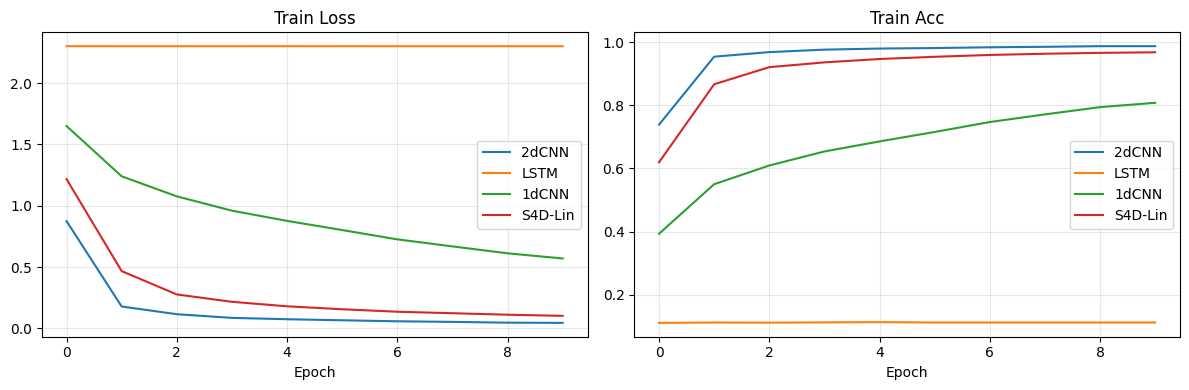

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for name, h in results.items():
    axes[0].plot(h['train_loss'], label=name)
    axes[1].plot(h['train_acc'], label=name)

axes[0].set_title('Train Loss')
axes[1].set_title('Train Acc')

for ax in axes.flat:
    ax.set_xlabel('Epoch')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()